In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [2]:
all_train = pd.read_csv('train_test.csv', names=['img_name','1st_result','1st_score','2nd_result','2nd_score',
                                           '3rd_result','3rd_score','4th_result','4th_score',
                                           '5th_result','5th_score','segment','cls'])
train = pd.read_csv('training.csv', names=['img_name','1st_result','1st_score','2nd_result','2nd_score',
                                           '3rd_result','3rd_score','4th_result','4th_score',
                                           '5th_result','5th_score','segment','cls'])
test = pd.read_csv('testing.csv', names=['img_name','1st_result','1st_score','2nd_result','2nd_score',
                                         '3rd_result','3rd_score','4th_result','4th_score',
                                         '5th_result','5th_score','segment','cls'])
all_train.drop('img_name', axis=1, inplace=True)
test.drop('img_name', axis=1, inplace=True)
train.drop('img_name', axis=1, inplace=True)
train.head()

1st_result  1st_score  \
0                                    dam, dike, dyke   0.079421   
1               seashore, coast, seacoast, sea-coast   0.110984   
2  worm fence, snake fence, snake-rail fence, Vir...   0.111187   
3                               doormat, welcome mat   0.048527   
4                                    maze, labyrinth   0.359694   

                                   2nd_result  2nd_score           3rd_result  \
0  solar dish, solar collector, solar furnace   0.057878  lakeside, lakeshore   
1                         lakeside, lakeshore   0.067503            monastery   
2              mobile home, manufactured home   0.052045                 pole   
3                                       broom   0.026041              sundial   
4        seashore, coast, seacoast, sea-coast   0.109345    sandbar, sand bar   

   3rd_score                       4th_result  4th_score  \
0   0.050353                   patio, terrace   0.047485   
1   0.040836              bell cote, bell cot   0.024820   
2   0.026348  greenhouse, nursery, glasshouse   0.026229   
3   0.019719                   patio, terrace   0.014585   
4   0.052152              lakeside, lakeshore   0.025826   

                                          5th_result  5th_score   segment  cls  
0               seashore, coast, seacoast, sea-coast   0.030495       Car    0  
1                                        street sign   0.024058      Road    0  
2                                lumbermill, sawmill   0.023403  Pavement    0  
3                                      parking meter   0.014006      Road    0  
4  leatherback turtle, leatherback, leathery turt...   0.024705      Road    0

### Processing data for XGBoost

In [3]:
def preprocess(features): 
    features = features.drop('1st_score', axis=1)    
    features = features.drop('2nd_score', axis=1)
    features = features.drop('3rd_score', axis=1)    
    features = features.drop('4th_score', axis=1)
    features = features.drop('5th_score', axis=1)
    
    for c in features.columns:
        features[c]=features[c].fillna(-1)
        if features[c].dtype == 'object':
            lbl = LabelEncoder()
            lbl.fit(list(features[c].values))
            features[c] = lbl.transform(list(features[c].values))
    return features

In [4]:
all_train = preprocess(all_train)
train = preprocess(train)
test = preprocess(test)
train.head()

1st_result  2nd_result  3rd_result  4th_result  5th_result  segment  cls
0         207         607         397         507         637        2    0
1         513         378         451         132         696        7    0
2         660         429         522         330         457        4    0
3         219         156         662         507         535        7    0
4         363         579         578         401         439        7    0

In [5]:
x_train = train.drop(['cls'], axis=1)
y_train = train['cls'].values
print('train:',x_train.shape, y_train.shape)

x_valid = test.drop(['cls'], axis=1)
y_valid = test['cls'].values
print('test:',x_valid.shape, y_valid.shape)

mean_all = np.mean(all_train['cls'].values)
mean_train = np.mean(y_train)
mean_valid = np.mean(y_valid)
print('correct:', mean_all,',',mean_train,',',mean_valid)

train: (50920, 6) (50920,)
test: (10000, 6) (10000,)
correct: 0.277445830598 , 0.233739198743 , 0.5


In [6]:
def xgb_run(params, x_train, x_valid, y_train, y_valid):
    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)
  
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

    d_test = xgb.DMatrix(x_valid)
    y_xgb = clf.predict(d_test)

    sns.set(font_scale = 1.5)
    xgb.plot_importance(clf)
    
    predictions = [round(value) for value in y_xgb]
    mean_valid = np.mean(predictions)
    print('mean:', mean_valid)
    
    return clf

[0]	train-error:0.233366	valid-error:0.4975
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[10]	train-error:0.233739	valid-error:0.5
[20]	train-error:0.233739	valid-error:0.5
[30]	train-error:0.233739	valid-error:0.5
[40]	train-error:0.233739	valid-error:0.5
[50]	train-error:0.233739	valid-error:0.5
[60]	train-error:0.233739	valid-error:0.5
[70]	train-error:0.233739	valid-error:0.5
[80]	train-error:0.233739	valid-error:0.5
[90]	train-error:0.233739	valid-error:0.5
[100]	train-error:0.233739	valid-error:0.5
Stopping. Best iteration:
[0]	train-error:0.233366	valid-error:0.4975

mean: 0.0


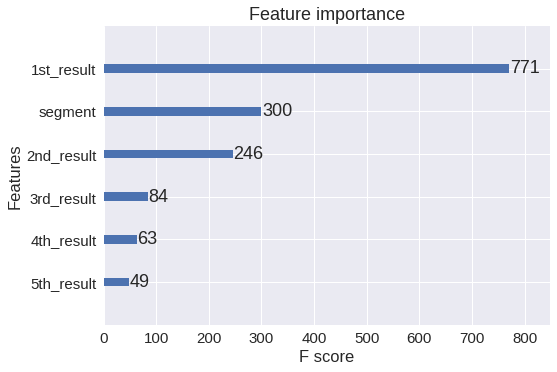

In [7]:
# reg:linear, reg:logistic, binary:logistic, rank:pairwise,reg:gamma,reg:tweedie,
# multi:softprob, multi:softmax, count:poisson, binary:logitraw
params = {
    'eta': 0.01,
    'objective': 'reg:linear',
    'eval_metric': 'error',
    'max_depth': 4,
    'silent': 1,
    'lambda':0.8,
    'subsample': 0.8,
    'alpha': 0.4,
    'gamma': 0,
}
clf = xgb_run(params, x_train, x_valid, y_train, y_valid)

In [8]:
def pca_fit(features):
    pca = PCA(n_components=2)
    return pca.fit_transform(features)

def tsne_fit(features):
    pca = PCA(n_components=4)
    tsne = TSNE(n_components=2)
    features = tsne.fit_transform(pca.fit_transform(features))
    return features

def plot(features, cls):
    plt.figure(figsize=(30,25))
    cmap = cm.rainbow(np.linspace(0.0, 1.0, 2))
    colors = cmap[cls]
        
    x = features[:, 0]
    y = features[:, 1]
    plt.scatter(x, y, c=colors)
    plt.show()

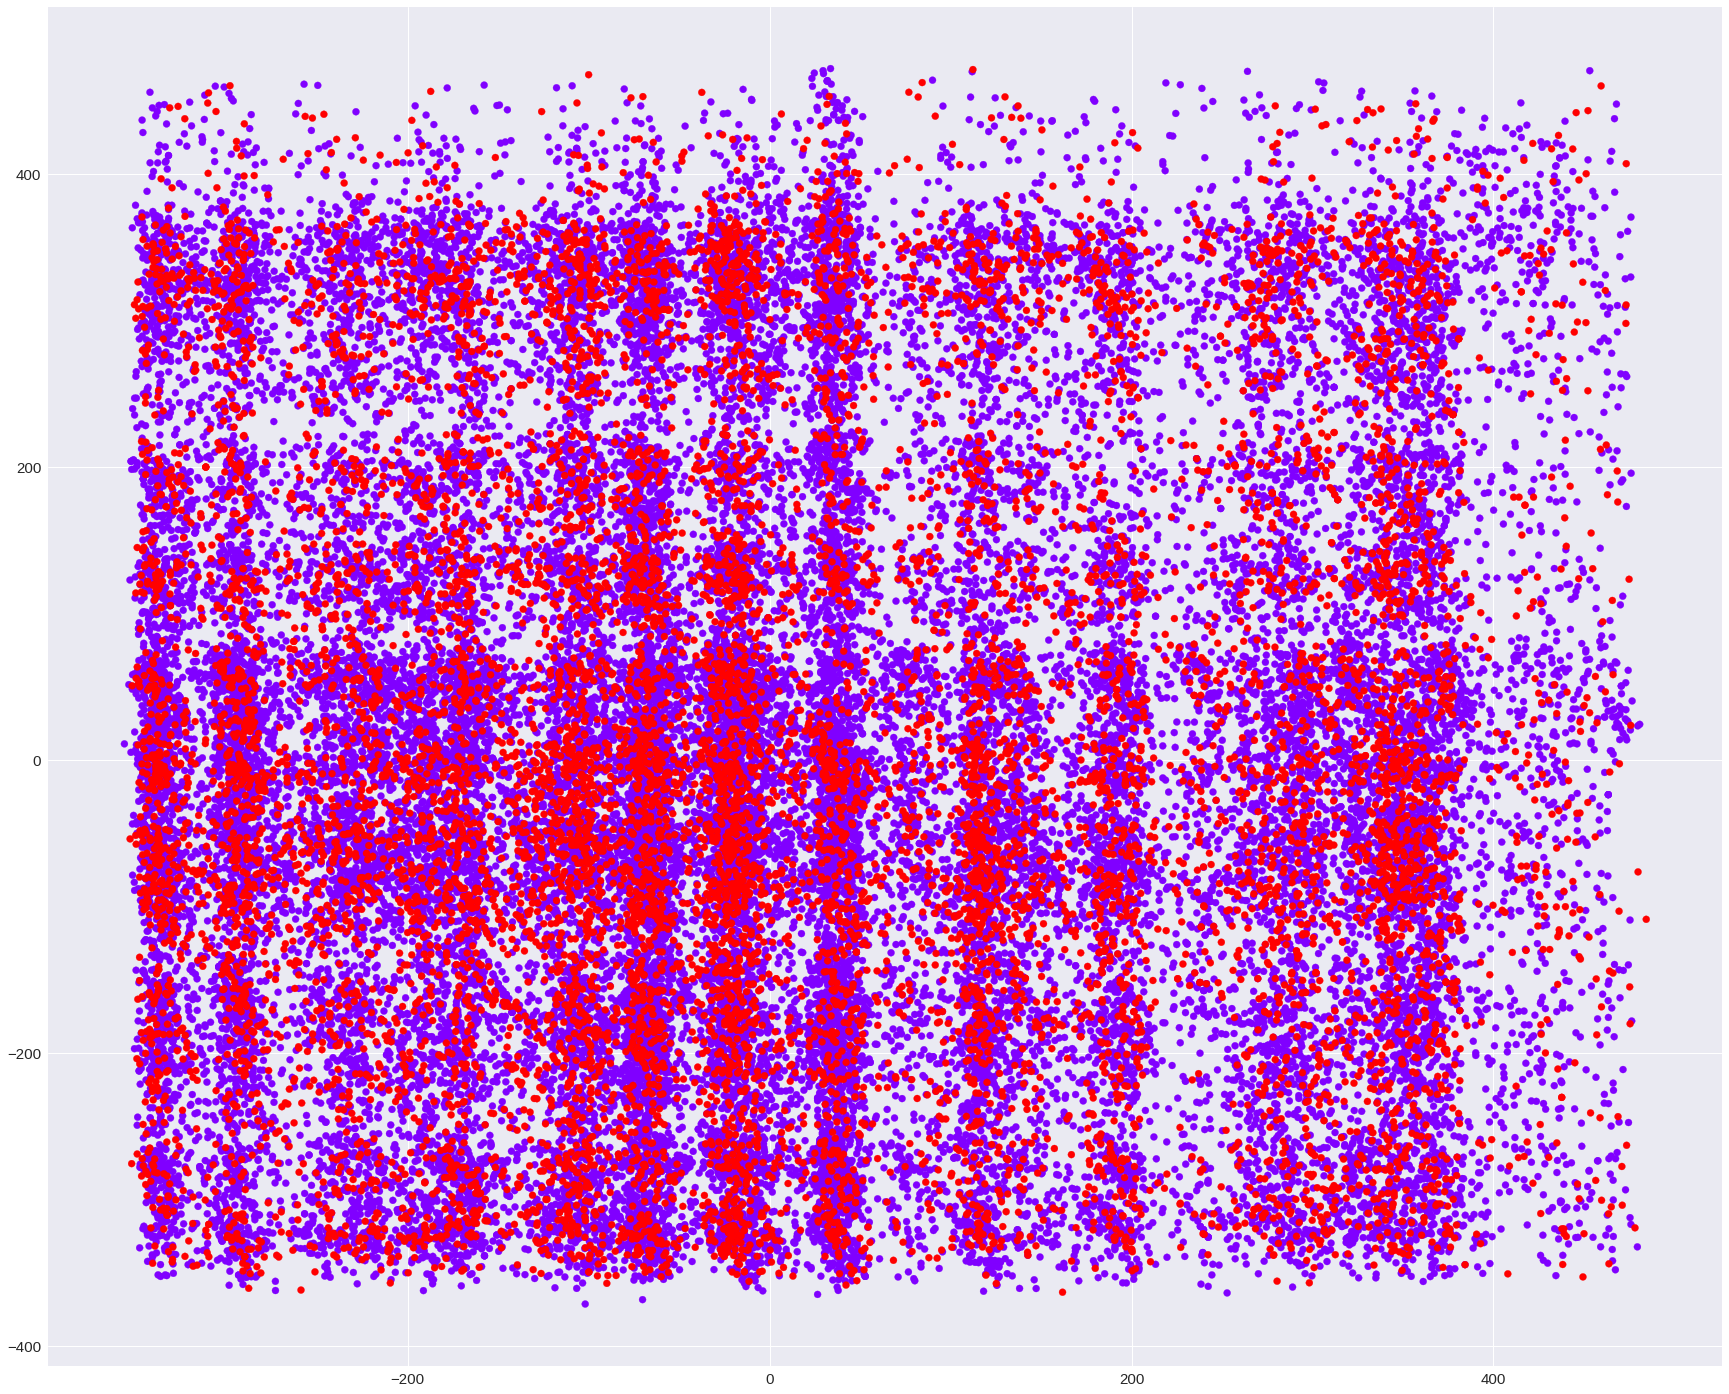

In [9]:
features = pca_fit(x_train)
plot(features, y_train)

## Using Top-1 result & Threshold

In [10]:
del all_train, train, test, x_train, x_valid, y_train, y_valid, mean_train, mean_valid

In [11]:
train = pd.read_csv('train_test.csv', names=['img_name','1st_result','1st_score','2nd_result','2nd_score',
                                           '3rd_result','3rd_score','4th_result','4th_score',
                                           '5th_result','5th_score','segment','cls'])
train.drop('img_name', axis=1, inplace=True)

In [12]:
breeding_sites = [ 
                'pot, flowerpot', 
                'stupa, tope', 
                'water jug', 
                'water bottle', 
                'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin', 
                'greenhouse, nursery, glasshouse', 
                'milk can', 
                'barrel, cask', 
                'canoe', 
                'rain barrel', 
                'lakeside, lakeshore', 
                'Dutch oven' 
                ]

def select_rows(df, breeding_sites, threshold=0.1):
    df = df[df['1st_score'] >= threshold]
    print('after threshold:',len(df))
    temp = df.loc[df['1st_result'].isin(breeding_sites)]
    return temp

In [13]:
print('all_train:',train.shape)
train_selected = select_rows(train, breeding_sites, threshold=0.15)             
train_selected = preprocess(train_selected)

x_train = train_selected.drop(['cls'], axis=1)
y_train = train_selected['cls'].values
print('train:', x_train.shape, y_train.shape,'\n')

mean_train = np.mean(y_train)
print('inception correctness:', mean_train,'\n')

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, random_state=7)
print('valid:', x_valid.shape, y_valid.shape)

mean_train = np.mean(y_train)
mean_valid = np.mean(y_valid)
print('mean_train, mean_valid:', mean_train,',',mean_valid)

all_train: (60920, 12)
after threshold: 32658
train: (7456, 6) (7456,) 

inception correctness: 0.505364806867 

valid: (2237, 6) (2237,)
mean_train, mean_valid: 0.509101360414 , 0.496647295485


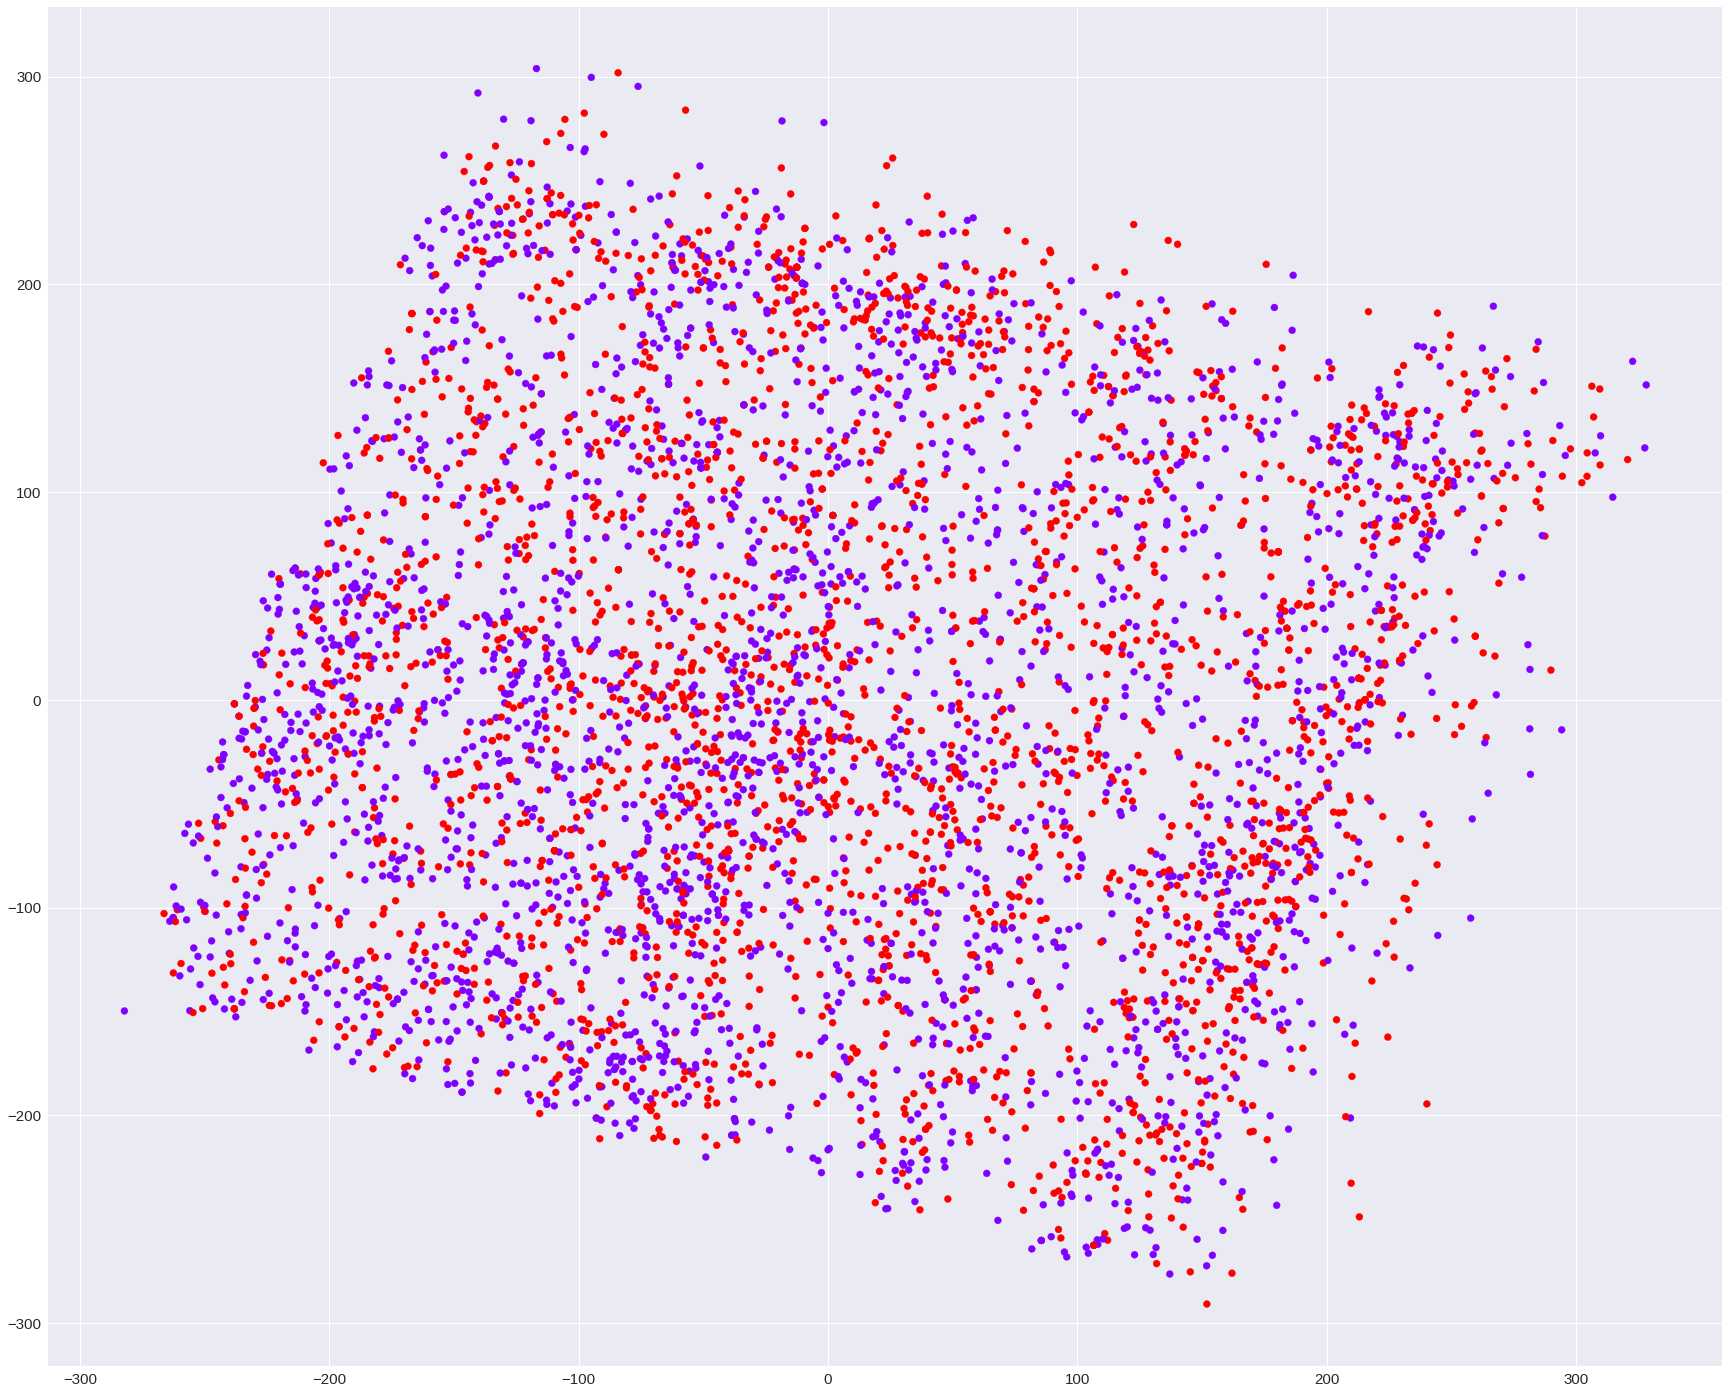

In [14]:
features = pca_fit(x_train)
plot(features, y_train)

[0]	train-error:0.333206	valid-error:0.382208
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[10]	train-error:0.301399	valid-error:0.361198
[20]	train-error:0.291052	valid-error:0.358516
[30]	train-error:0.288944	valid-error:0.353599
[40]	train-error:0.28722	valid-error:0.353599
[50]	train-error:0.282238	valid-error:0.34734
[60]	train-error:0.281088	valid-error:0.346446
[70]	train-error:0.273807	valid-error:0.344211
[80]	train-error:0.273424	valid-error:0.343764
[90]	train-error:0.269975	valid-error:0.343317
[100]	train-error:0.265951	valid-error:0.34287
[110]	train-error:0.264035	valid-error:0.344211
[120]	train-error:0.26097	valid-error:0.340635
[130]	train-error:0.259053	valid-error:0.340635
[140]	train-error:0.259437	valid-error:0.340188
[150]	train-error:0.257329	valid-error:0.341082
[160]	train-error:0.251772	valid-error:0.343317
[170]	train-error:0.249665	valid-error:0.3384
[180]

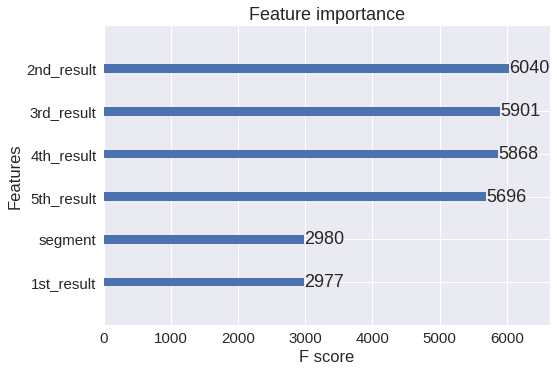

In [15]:
# reg:linear, reg:logistic, binary:logistic, rank:pairwise,reg:gamma,reg:tweedie,
# multi:softprob, multi:softmax, count:poisson, binary:logitraw
params = {
    'eta': 0.01,
    'objective': 'reg:linear',
    'eval_metric': 'error',
    'max_depth': 6,
    'silent': 1,
    'lambda':0.8,
    'subsample': 0.8,
    'alpha': 0.4,
    'gamma': 0,
}
clf = xgb_run(params, x_train, x_valid, y_train, y_valid)

In [16]:
clf.save_model('xgb.model')

In [21]:
bst = xgb.Booster() 
bst.load_model('xgb.model')
bst.predict(xgb.DMatrix(x_train))

array([ 0.63714564,  0.66408211,  0.79012835, ...,  0.27497762,
        0.25404397,  0.72344267], dtype=float32)